In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["clean_trace", "std_phon_trace", "phonetic_trace","traces_fourier", "syllables_fourier"]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")

## Import

In [21]:
# Load dataset
df = pd.read_csv(DF_PREPROC_FILE)

# Load timeseries
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

## Motifs on clean traces

In [3]:
import stumpy
from matplotlib.patches import Rectangle

motif 0 is in 5494 --> 5678
skipped 5678 because is equal to nearest 5678
motif 1 is in 3564 --> 1942


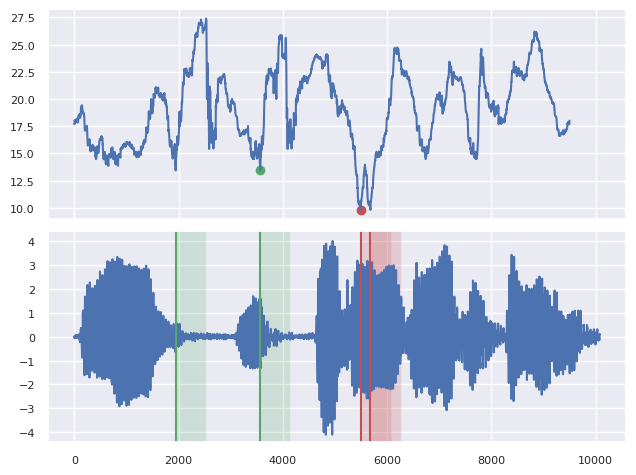

In [4]:
from scipy.signal import argrelmin, find_peaks

m = 580
test_track = traces['clean_trace'][25]
test_track = test_track[np.logical_not(np.isnan(test_track))]

fig, (axmat, axts ) = plt.subplots(2,1,sharex=True)
axts.set_ylim(-1.1*np.max(test_track), 1.1*np.max(test_track))
axts.plot(test_track)


mp = stumpy.stump(test_track, m)
axmat.plot(mp[:,0])

peaks = find_peaks(-mp[:, 0], distance=m//10, prominence=0)

motif_idxs = peaks[0]
motif_idxs = motif_idxs[np.flip(np.argsort(peaks[1]["prominences"]))]

colors = ["r", "g"]
done = 0
count = 0
nearest_neighbor_idx = -1
real_motifs = []

while done < len(colors):    
    motif_idx = motif_idxs[count]
    if motif_idx != nearest_neighbor_idx:
        nearest_neighbor_idx = mp[motif_idx, 1]
        real_motifs.append(motif_idx)
        print(f"motif {done} is in {motif_idx} --> {nearest_neighbor_idx}")
        axmat.scatter([motif_idx], [mp[motif_idx, 0]], c=colors[done])

        axts.axvline(motif_idx, color=colors[done])
        rect = Rectangle((motif_idx, -20), m, 40, facecolor=colors[done], alpha=0.2)
        axts.add_patch(rect)

        axts.axvline(nearest_neighbor_idx, color=colors[done])
        rect = Rectangle((nearest_neighbor_idx, -20), m, 40, facecolor=colors[done], alpha=0.2)
        axts.add_patch(rect)
        
        count += 1 
        done += 1
    else:
        print(f"skipped {motif_idx} because is equal to nearest {nearest_neighbor_idx}")
        count +=1


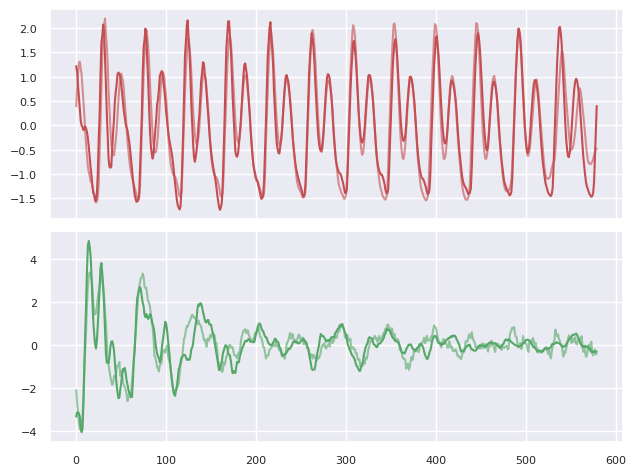

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pepo = lambda x: scaler.fit_transform(x.reshape(-1,1)).reshape(-1)

fig, axes = plt.subplots(len(real_motifs), 1, sharex=True)

for i, (motif,  color) in enumerate(zip(real_motifs, ["r","g"])):
    nearest_neighbor_idx = mp[motif, 1]

    axes[i].plot(pepo(test_track[motif:motif+m]), color=color, label=f"motif {i+1}")
    axes[i].plot(pepo(test_track[nearest_neighbor_idx:nearest_neighbor_idx + m]), color=color, alpha=0.6)


## Motifs on standardised short-time intensities

motif 0 is in 520 --> 18
motif 1 is in 239 --> 425


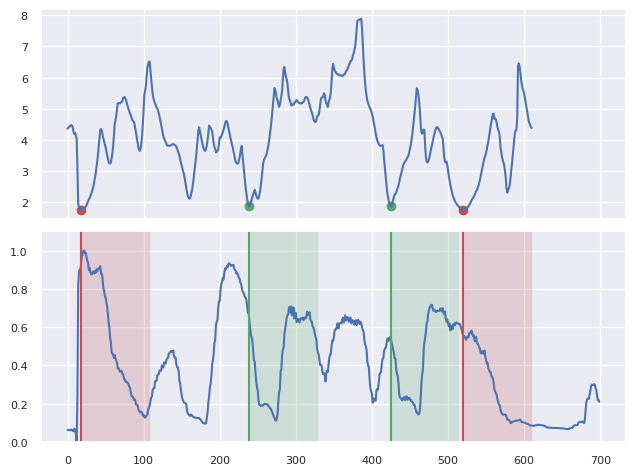

In [24]:
from scipy.signal import argrelmin, find_peaks

m = 90
test_track = traces['std_phon_trace'][0]

fig, (axmat, axts ) = plt.subplots(2,1,sharex=True)
axts.set_ylim(0, 1.1*np.max(test_track))
axts.plot(test_track)


mp = stumpy.stump(test_track, m)
axmat.plot(mp[:,0])

peaks = find_peaks(-mp[:, 0], distance=m//3, prominence=0)

motif_idxs = peaks[0]
motif_idxs = motif_idxs[np.flip(np.argsort(peaks[1]["prominences"]))]

colors = ["r", "g"]
done = 0
count = 0
nearest_neighbor_idx = -1
real_motifs = []

while done < len(colors):    
    motif_idx = motif_idxs[count]
    if motif_idx != nearest_neighbor_idx:
        nearest_neighbor_idx = mp[motif_idx, 1]
        real_motifs.append(motif_idx)
        print(f"motif {done} is in {motif_idx} --> {nearest_neighbor_idx}")
        
        axmat.scatter([motif_idx], [mp[motif_idx, 0]], c=colors[done])
        axmat.scatter([nearest_neighbor_idx], [mp[nearest_neighbor_idx, 0]], c=colors[done])

        axts.axvline(motif_idx, color=colors[done])
        rect = Rectangle((motif_idx, 0), m, 3, facecolor=colors[done], alpha=0.2)
        axts.add_patch(rect)

        axts.axvline(nearest_neighbor_idx, color=colors[done])
        rect = Rectangle((nearest_neighbor_idx, -1), m, 40, facecolor=colors[done], alpha=0.2)
        axts.add_patch(rect)
        
        count += 1 
        done += 1
    else:
        print(f"skipped {motif_idx} because is equal to nearest {nearest_neighbor_idx}")
        count +=1


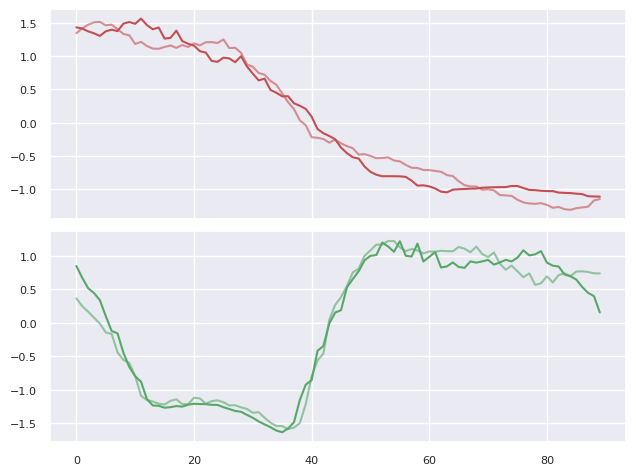

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pepo = lambda x: scaler.fit_transform(x.reshape(-1,1)).reshape(-1)

fig, axes = plt.subplots(len(real_motifs), 1, sharex=True)

for i, (motif,  color) in enumerate(zip(real_motifs, ["r","g"])):
    nearest_neighbor_idx = mp[motif, 1]

    axes[i].plot(pepo(test_track[motif:motif+m]), color=color, label=f"motif {i+1}")
    axes[i].plot(pepo(test_track[nearest_neighbor_idx:nearest_neighbor_idx + m]), color=color, alpha=0.6)


## Average motifs

Text(0.5, 1.0, 'Global average matrix profile')

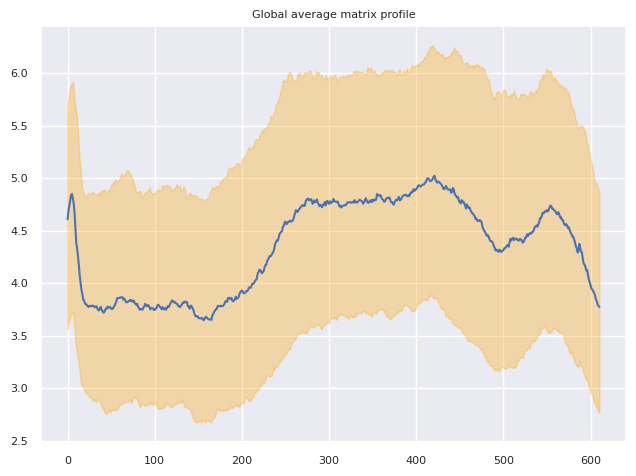

In [34]:
M = len(traces["std_phon_trace"])
m = 90

matrix_profiles = np.zeros((M, len(traces["std_phon_trace"][i])-m+1    ))

for i in range(M):
    matrix_profiles[i] = stumpy.stump(traces["std_phon_trace"][i], m)[:, 0]
    
low, median, upper = np.quantile(matrix_profiles, [0.25, 0.5, 0.75], axis=0)

plt.plot(median)
plt.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
plt.title("Global average matrix profile")

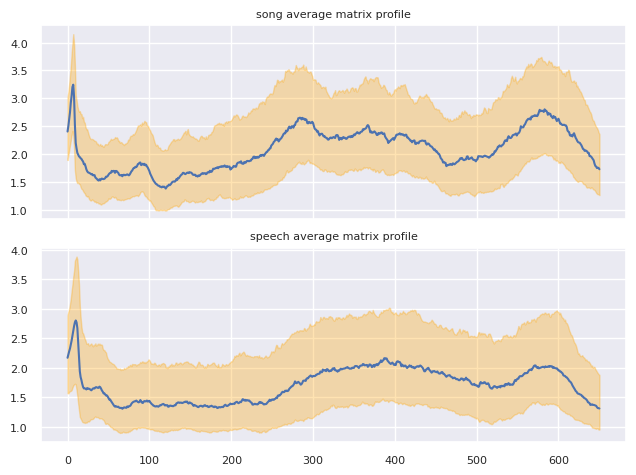

In [63]:
m = 50
fig, axes = plt.subplots(2, 1, sharex=True)
for vc,ax in zip(["song", "speech"], axes):
    subsample = traces["std_phon_trace"][df.vocal_channel ==vc]
    M = len(subsample)
    matrix_profiles = np.zeros((M, len(traces["std_phon_trace"][i])-m+1  ))

    for i in range(M):
        matrix_profiles[i] = stumpy.stump(subsample[i], m)[:, 0]

    low, median, upper = np.quantile(matrix_profiles, [0.25, 0.5, 0.75], axis=0)

    ax.plot(median)
    ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{vc} average matrix profile")

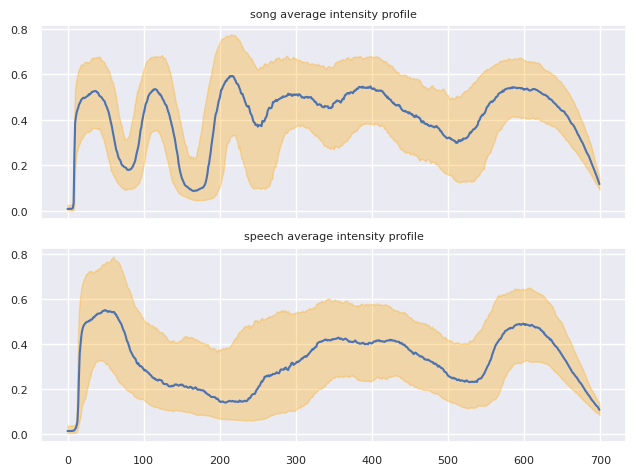

In [44]:
m = 90
fig, axes = plt.subplots(2, 1, sharex=True)
for vc,ax in zip(["song", "speech"], axes):
    subsample = np.vstack(traces["std_phon_trace"][df.vocal_channel ==vc])
    low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

    ax.plot(median)
    ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{vc} average intensity profile")

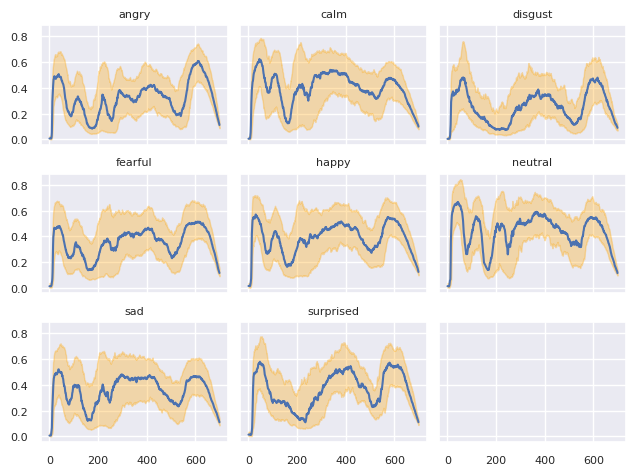

In [52]:
m = 90
fig, axes = plt.subplots(3,3, sharex=True, sharey=True)
axes = axes.flatten()
for vc,ax in zip(np.unique(df.emotion), axes):
    subsample = np.vstack(traces["std_phon_trace"][df.emotion ==vc])
    low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

    ax.plot(median)
    ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{vc}")

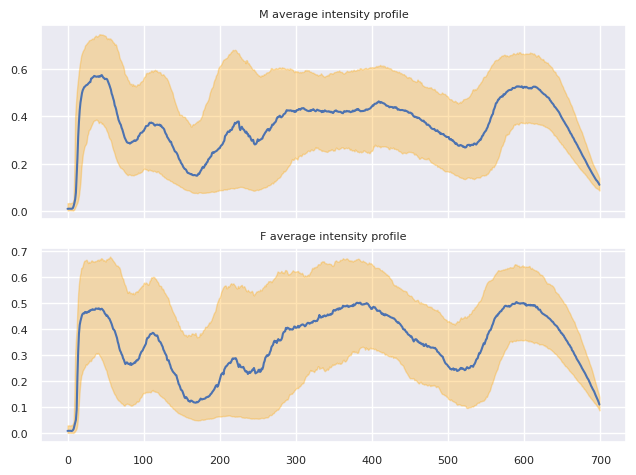

In [50]:
m = 90
fig, axes = plt.subplots(2, 1, sharex=True)
for s,ax in zip(["M", "F"], axes):
    subsample = np.vstack(traces["std_phon_trace"][df.sex == s])
    low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

    ax.plot(median)
    ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{s} average intensity profile")

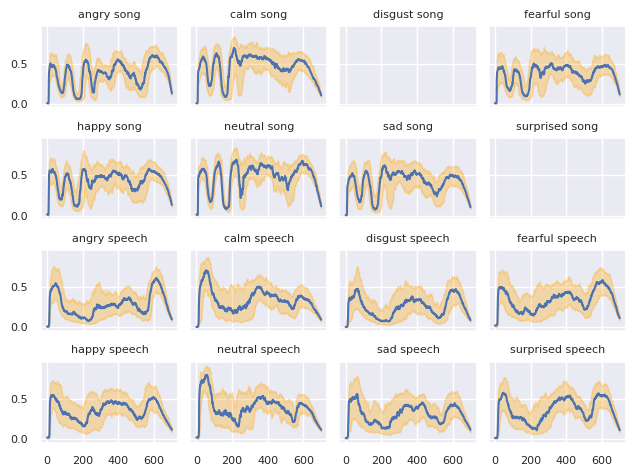

In [62]:
m = 90
fig, axes = plt.subplots(4,4, sharex=True, sharey=True)
axes = axes.flatten()

attrs = np.array([[ (vc, em) for em in np.unique(df.emotion)] for vc in np.unique(df.vocal_channel)]).reshape(-1,2)

for attr ,ax in zip(attrs, axes):
    subsample = traces["std_phon_trace"][(df.vocal_channel == attr[0])&(df.emotion==attr[1])]
    if len(subsample) > 0:
        subsample = np.vstack(subsample)
        low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

        ax.plot(median)
        ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{attr[1]} {attr[0]}")